## 1. 初期設定

In [ ]:
# !pip install numpy pandas scikit-learn matplotlib openjij dwave-neal

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
import openjij as oj
import neal
import time
from tqdm import tqdm

In [2]:
# --- 設定とハイパーパラメータ  ---
N_RUNS = 32              # 実行するSEEDの数 (0 to 31)
N_TRAIN = 128            # トレーニングデータ数 (n)
N_VAL = 128              # 検証データ数
N_TEST = 128             # テストデータ数
INPUT_DIM = 9            # 入力次元数
N0 = 64                  # 初期化ステップ数
N_TOTAL = 320            # 総ステップ数 (N)
M_SAMPLES = 512          # 1ステップあたりのサンプリング数 (M)

## 2. 補助関数

In [5]:
# データセット生成を生成する関数
def generate_data(n_samples, noise_ratio=0.0):
    X = np.random.randint(0, 2, (n_samples, INPUT_DIM))
    y_true = (X.sum(axis=1) > 4.5).astype(int)    # 正解ラベル: 合計が4.5以上なら1、それ以外は0
    y = y_true.copy()
    if noise_ratio > 0:
        n_noise = int(n_samples * noise_ratio)
        start_idx = n_samples - n_noise
        y[start_idx:] = 1 - y[start_idx:] # ラベル反転
    return X, y, y_true


# 代理モデル用の特徴量変換を行う関数
def get_poly_features(q_history):
    """
    qベクトルから2次の相互作用項を作成する。
    Ridge回帰の入力として使用。 p = 1 + n + n(n-1)/2
    """
    # scikit-learnのPolynomialFeaturesを使って相互作用項(degree=2)を生成
    # include_bias=Trueで定数項(alpha_0)も含める
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=True)
    return poly.fit_transform(q_history)


# QUBO行列への変換ロジック
def ridge_to_qubo(coef, n_dim):
    """
    Ridge回帰の係数をQUBO行列 Q に変換する。
    QUBOでは線形項 h_i は 対角成分 Q_ii として扱われる (x_i^2 = x_i なので)。
    """
    Q = {}

    # 線形項 (index 1 to n) -> 対角成分 Q[(i, i)]
    for i in range(n_dim):
        Q[(i, i)] = coef[i + 1]

    # 相互作用項 (index n+1 以降) -> 非対角成分 Q[(i, j)]
    k = n_dim + 1
    for i in range(n_dim):
        for j in range(i + 1, n_dim):
            Q[(i, j)] = coef[k]
            k += 1

    return Q

# 指定されたSEEDで最適化を1回実行し、結果を返す関数
def run_optimization(seed):
    # SEED固定
    np.random.seed(seed)

    # データ生成 (後半64件がノイズ)
    X_train, y_train, _ = generate_data(N_TRAIN, noise_ratio=0.5)
    X_val, y_val, _ = generate_data(N_VAL, noise_ratio=0.0)

    # 評価関数
    def evaluate_subset(q_mask):
        indices = np.where(q_mask == 1)[0]
        if len(indices) < 10: return 10.0
        model = LogisticRegression(solver='liblinear', random_state=seed)
        try:
            model.fit(X_train[indices], y_train[indices])
            y_pred_prob = model.predict_proba(X_val)
            return log_loss(y_val, y_pred_prob)
        except ValueError:
            return 10.0

    # 最適化ループ変数
    history_q = []
    history_loss = []
    best_q = None
    best_loss = float('inf')

    sampler = neal.SimulatedAnnealingSampler()
    # sampler = oj.SQASampler()

    for k in range(N_TOTAL):
        if k < N0:
            q_candidate = np.random.randint(0, 2, N_TRAIN)
            if q_candidate.sum() == 0: q_candidate[0] = 1
        else:
            target_y = np.log(np.array(history_loss))
            X_surrogate = get_poly_features(np.array(history_q))
            regr = Ridge(alpha=1.0)
            regr.fit(X_surrogate, target_y)

            full_coef = np.concatenate(([regr.intercept_], regr.coef_[1:]))
            Q = ridge_to_qubo(full_coef, N_TRAIN)

            response = sampler.sample_qubo(Q, num_reads=M_SAMPLES)

            samples = response.record['sample']
            energies = response.record['energy']
            sorted_indices = np.argsort(energies)

            found_new = False
            seen_set = set(tuple(x) for x in history_q)

            for idx in sorted_indices:
                candidate = samples[idx]
                if tuple(candidate) not in seen_set:
                    q_candidate = candidate
                    found_new = True
                    break

            if not found_new:
                q_candidate = np.random.randint(0, 2, N_TRAIN)

        loss = evaluate_subset(q_candidate)
        history_q.append(q_candidate)
        history_loss.append(loss)

        if loss < best_loss:
            best_loss = loss
            best_q = q_candidate.copy()

    # --- 最終精度の計算 (Accuracy) ---
    # テストデータ生成
    X_test, y_test, _ = generate_data(N_TEST, noise_ratio=0.0)

    def get_acc(q_mask):
        indices = np.where(q_mask == 1)[0]
        if len(indices) == 0: return 0.0
        model = LogisticRegression(solver='liblinear', random_state=seed)
        model.fit(X_train[indices], y_train[indices])
        return accuracy_score(y_test, model.predict(X_test))

    acc_before = get_acc(np.ones(N_TRAIN)) # 全データ使用
    acc_after = get_acc(best_q)            # クレンジング後

    return best_q, acc_before, acc_after

## 3. 実行

In [6]:
# --- メイン実行ループ ---
results_q_masks = []
results_acc_before = []
results_acc_after = []

print(f"Running {N_RUNS} seeds using Neal SA...")
start_total = time.time()

for seed in tqdm(range(N_RUNS), desc="Optimization"):
    best_q, acc_pre, acc_post = run_optimization(seed)

    results_q_masks.append(best_q)
    results_acc_before.append(acc_pre)
    results_acc_after.append(acc_post)

total_elapsed = time.time() - start_total
avg_time = total_elapsed / N_RUNS

print(f"\nDone! Total time: {total_elapsed:.1f}s")
print(f"Average time per seed: {avg_time:.2f}s")

Running 32 seeds using Neal SA...


Optimization: 100%|██████████| 32/32 [5:45:24<00:00, 647.65s/it]


Done! Total time: 20724.8s
Average time per seed: 647.65s


## 4. 結果の可視化

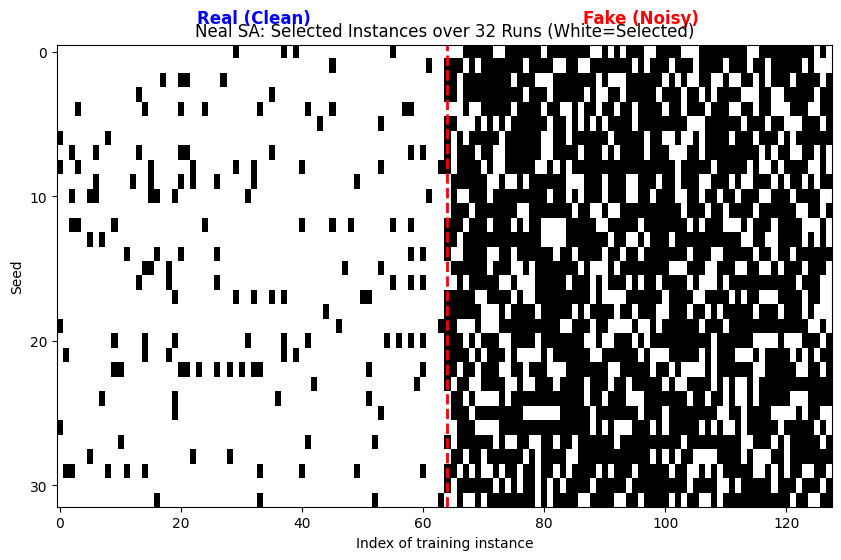

In [7]:
# --- 可視化 1: Selection Pattern (Figure 2 再現) ---
plt.figure(figsize=(10, 6))
# 行列化 (32 seeds x 128 instances)
mask_matrix = np.array(results_q_masks)

plt.imshow(mask_matrix, aspect='auto', cmap='gray', interpolation='nearest')
plt.axvline(x=64, color='r', linestyle='--', linewidth=2) # ノイズ境界

plt.ylabel('Seed')
plt.xlabel('Index of training instance')
plt.title('Neal SA: Selected Instances over 32 Runs (White=Selected)')
plt.text(32, -2, 'Real (Clean)', ha='center', color='blue', fontsize=12, fontweight='bold')
plt.text(96, -2, 'Fake (Noisy)', ha='center', color='red', fontsize=12, fontweight='bold')
plt.yticks(np.arange(0, 33, 10)) # 目盛り調整
plt.show()

/tmp/ipython-input-2164626200.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_to_plot, patch_artist=True, labels=['Before (All)', 'After (Optimized)'])


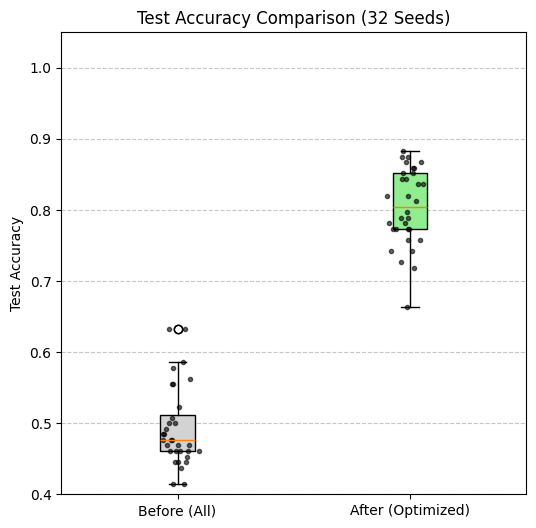

Average Accuracy (Before): 0.4934
Average Accuracy (After) : 0.8044


In [8]:
# --- 可視化 2: Accuracy Comparison (Figure 3 風) ---
plt.figure(figsize=(6, 6))
data_to_plot = [results_acc_before, results_acc_after]

# 箱ひげ図
bp = plt.boxplot(data_to_plot, patch_artist=True, labels=['Before (All)', 'After (Optimized)'])

# デザイン調整
colors = ['lightgray', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# 個別のデータ点を散布図として重ねる (Jitter plot)
for i, data in enumerate(data_to_plot):
    y = data
    x = np.random.normal(i + 1, 0.04, size=len(y)) # 少し横にずらす
    plt.plot(x, y, 'k.', alpha=0.6)

plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison (32 Seeds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.4, 1.05) # 50%〜100%を見やすく
plt.show()

# 平均値の表示
print(f"Average Accuracy (Before): {np.mean(results_acc_before):.4f}")
print(f"Average Accuracy (After) : {np.mean(results_acc_after):.4f}")